In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [33]:
hrEmployeeData = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv', dtype={'BusinessTravel': str})
xAxis = 'JobInvolvement'
yAxis = 'MonthlyRate'

(0, 31048.849999999999)

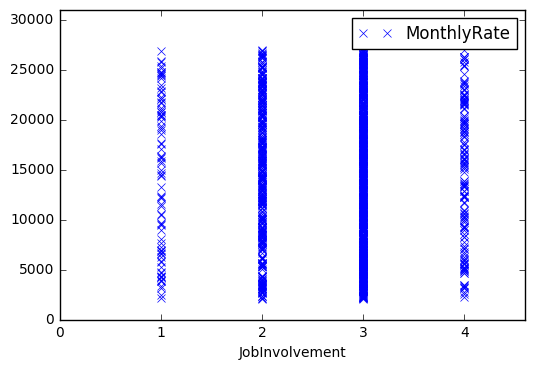

In [34]:
promotionVsHourly = hrEmployeeData.plot(x=xAxis, y=yAxis, style='x')
promotionVsHourly.set_xlim(0, hrEmployeeData[xAxis].max() * 1.15)
promotionVsHourly.set_ylim(0, hrEmployeeData[yAxis].max() * 1.15)

In [35]:
hrData = hrEmployeeData.as_matrix([xAxis, yAxis])

## Convert Categorical Data to Dummy Variables

In [36]:
"""
inputVals: vector in form of [x1, x2, ..., xn]
beta: vector of beta coefficients in form [b0, b1, b2, ..., bn]
"""
def linRegEstimate(inputVals, beta):
    inputMatrix = np.array([1] + inputVals)
    print('input matrix:', inputMatrix)
    print('multiply:', inputMatrix * beta)
    return np.sum(inputMatrix * beta)


"""
matrix: matrix of points in form [[x1, x2, ..., xn], ...]
returns: (beta, pearsonCorrelation) tuple
"""
def computeLinRegBeta(matrix):
    inputMatrix = np.array(matrix)
    m = len(inputMatrix)
    x = np.array([np.ones(m), inputMatrix[:, 0]]).T
    print('X transposed:', x)
    y = np.array(inputMatrix[:, 1]).reshape(-1, 1)
    print(y)
    beta = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
    print('Beta:', beta.T)
    
    return beta.T[0], np.corrcoef(x.T[1], y.T[0])[0, 1] ** 2

In [55]:
def categoricalColumnNames(columnName, attributeList):
    return ['{}_{}'.format(columnName, attribute)
            for attribute in attributeList]

# Convert nominal variable x to its dummy vector variable representation
def _convertNominalVariable(dataFrame, columnName):
    attrValues = dataFrame[columnName].unique()
#     newColumns = ['{}_{}'.format(columnName, attr) for attr in attrValues]
    newColumns = categoricalColumnNames(columnName, attrValues)
    encodingList = [np.zeros(len(attrValues) - 1) for attr in attrValues]
    
    for newColumn, value in zip(newColumns, attrValues):
        dataFrame[newColumn] = pd.Series()
        dataFrame.loc[dataFrame[columnName] == value, newColumn] = 1
        dataFrame.loc[dataFrame[columnName] != value, newColumn] = 0
    
    for i in range(1, len(attrValues)):
        encodedAttr = encodingList[i]
        encodedAttr[i - 1] = 1
    
    return dataFrame


def convertNominalVariables(dataFrame, columnList):
    newDf = pd.DataFrame(dataFrame)
    
    for attribute in columnList:
        newDf = _convertNominalVariable(newDf, attribute)
    return newDf
        
    
# Convert ordinal variable x to its dummy vector variable representation
def _convertOrdinalVariable(dataFrame, columnName, orderedAttributes):
    oneHotDf = _convertNominalVariable(dataFrame, columnName)
    newAttrNames = categoricalColumnNames(columnName, orderedAttributes)
    print(newAttrNames)
    attrIndices = {}
    
    for i, attr in enumerate(orderedAttributes):
        attrIndices[attr] = i
    
    for i, newOldAttr in enumerate(zip(orderedAttributes, newAttrNames)):
        oldAttr, newAttr = newOldAttr
        print('Checking for {}. Setting [{}] to 1'.format(oldAttr, newAttrNames[:i + 1]))
        for attrName in newAttrNames[:i]:
            oneHotDf.loc[oneHotDf[columnName] == oldAttr, attrName] = 1
    print(oneHotDf[newAttrNames])

    
# newDf = pd.get_dummies(hrEmployeeData, columns=['EducationField'])
convertedDf = convertNominalVariables(hrEmployeeData, ['EducationField'])
# print(convertedDf)

# print(newDf)
# print(hrEmployeeData['EducationField'].unique())
_convertOrdinalVariable(hrEmployeeData, 'BusinessTravel', ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'])
# _convertOrdinalVariable(hrEmployeeData, 'EducationField', ['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources'])

['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely', 'BusinessTravel_Travel_Frequently']
Checking for Non-Travel. Setting [['BusinessTravel_Non-Travel']] to 1
Checking for Travel_Rarely. Setting [['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely']] to 1
Checking for Travel_Frequently. Setting [['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Rarely', 'BusinessTravel_Travel_Frequently']] to 1
      BusinessTravel_Non-Travel  BusinessTravel_Travel_Rarely  \
0                           1.0                           1.0   
1                           1.0                           1.0   
2                           1.0                           1.0   
3                           1.0                           1.0   
4                           1.0                           1.0   
5                           1.0                           1.0   
6                           1.0                           1.0   
7                           1.0                           1.0 

## Check R^2 to SciPy results

In [38]:
def checkR2(x, y):
    slope, intercept, r2, p_val, std_err = stats.linregress(x, y)
    print('slope={}, intercept={}, R2={}'.format(slope, intercept, r2))

In [39]:
coefficients, correlation = computeLinRegBeta(np.array([[1, 6], [2, 5], [3, 7], [4, 10]]))
print('Coefficients: {}, R2: {}'.format(coefficients, correlation))
checkR2([1, 2, 3, 4], [6, 5, 7, 10])

X transposed: [[ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]]
[[ 6]
 [ 5]
 [ 7]
 [10]]
Beta: [[ 3.5  1.4]]
Coefficients: [ 3.5  1.4], R2: 0.7000000000000001
slope=1.4, intercept=3.5, R2=0.8366600265340756


In [40]:
linRegEstimate([3], coefficients)

input matrix: [1 3]
multiply: [ 3.5  4.2]


7.7000000000000037

In [41]:
hrBeta, hrCorrelation = computeLinRegBeta(hrData)
print('HR Pearson Correlation coefficient:', hrCorrelation)

X transposed: [[ 1.  3.]
 [ 1.  2.]
 [ 1.  2.]
 ..., 
 [ 1.  4.]
 [ 1.  2.]
 [ 1.  4.]]
[[19479]
 [24907]
 [ 2396]
 ..., 
 [ 5174]
 [13243]
 [10228]]
Beta: [[ 14758.82123105   -163.27067272]]
HR Pearson Correlation coefficient: 0.000266410264623
